<a href="https://colab.research.google.com/github/Septiana2216/portofolio/blob/main/Septiana_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# digits: 10; # samples: 1797; # features 64
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.316s	69545	0.598	0.645	0.621	0.469	0.617	0.161
random   	0.192s	69735	0.681	0.723	0.701	0.574	0.698	0.181
PCA-based	0.067s	69513	0.600	0.647	0.622	0.468	0.618	0.156
__________________________________________________________________________________


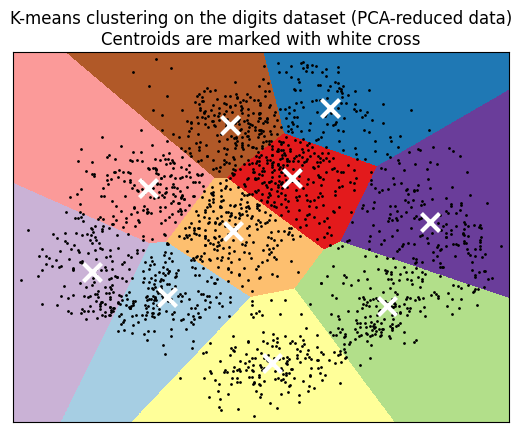

In [ ]:
# Authors: Septiana Istijabah
# SPDX-License-Identifier: BSD-3-Clause

import numpy as np
import matplotlib.pyplot as plt
from time import time

from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# -----------------------------------------------------------------------------
# Load dataset
# -----------------------------------------------------------------------------
data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size
print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# -----------------------------------------------------------------------------
# Benchmarking function
# -----------------------------------------------------------------------------
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods."""
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    results += [
        metrics.silhouette_score(
            data, estimator[-1].labels_, metric="euclidean", sample_size=300
        )
    ]

    # Display the results
    formatter = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter.format(*results))

# -----------------------------------------------------------------------------
# Run benchmarks with different initialization methods
# -----------------------------------------------------------------------------
print("_" * 82)
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans, "k-means++", data, labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans, "random", data, labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans, "PCA-based", data, labels)

print("_" * 82)

# -----------------------------------------------------------------------------
# Visualize the clustering result in 2D using PCA
# -----------------------------------------------------------------------------
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Mesh step size
h = 0.02

# Mesh boundaries
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict cluster index for each point in the mesh
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotting
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)

# Plot centroids
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)

plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()